In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import geopandas

from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from fuzzywuzzy import fuzz, process
from shapely.geometry import Point, MultiPoint, Polygon

%matplotlib inline

/Users/aRa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Import data of italian regions from Protezione Civile
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
df_data = pd.read_csv(url, parse_dates=['data'])

df_data['data'] = df_data['data'].dt.date # Get only day part without timezone information
df_data.set_index(['data','denominazione_regione'], inplace=True)

region_names = df_data.index.get_level_values(1).unique().tolist() # Save region names
print(region_names)

['Abruzzo', 'Basilicata', 'P.A. Bolzano', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'P.A. Trento', 'Umbria', "Valle d'Aosta", 'Veneto']


## Last day's data
Show data updated to last day

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv'
df_lastday = pd.read_csv(url, parse_dates=['data'])
df_lastday['data'] = df_lastday['data'].dt.date # Get only day part without timezone information
df_lastday.set_index(['data','denominazione_regione'], inplace=True)
df_lastday

stato  codice_regione        lat       long  \
data       denominazione_regione                                               
2020-04-17 Abruzzo                 ITA              13  42.351222  13.398438   
           Basilicata              ITA              17  40.639471  15.805148   
           P.A. Bolzano            ITA               4  46.499335  11.356624   
           Calabria                ITA              18  38.905976  16.594402   
           Campania                ITA              15  40.839566  14.250850   
           Emilia-Romagna          ITA               8  44.494367  11.341721   
           Friuli Venezia Giulia   ITA               6  45.649435  13.768136   
           Lazio                   ITA              12  41.892770  12.483667   
           Liguria                 ITA               7  44.411493   8.932699   
           Lombardia               ITA               3  45.466794   9.190347   
           Marche                  ITA              11  43.616760  13.518875   
           Molise                  ITA              14  41.557748  14.659161   
           Piemonte                ITA               1  45.073274   7.680687   
           Puglia                  ITA              16  41.125596  16.867367   
           Sardegna                ITA              20  39.215312   9.110616   
           Sicilia                 ITA              19  38.115697  13.362357   
           Toscana                 ITA               9  43.769231  11.255889   
           P.A. Trento             ITA               4  46.068935  11.121231   
           Umbria                  ITA              10  43.106758  12.388247   
           Valle d'Aosta           ITA               2  45.737503   7.320149   
           Veneto                  ITA               5  45.434905  12.338452   

                                  ricoverati_con_sintomi  terapia_intensiva  \
data       denominazione_regione                                              
2020-04-17 Abruzzo                                   319                 43   
           Basilicata                                 59                  9   
           P.A. Bolzano                              181                 32   
           Calabria                                  154                  7   
           Campania                                  622                 76   
           Emilia-Romagna                           3330                309   
           Friuli Venezia Giulia                     148                 23   
           Lazio                                    1332                187   
           Liguria                                   897                105   
           Lombardia                               10627                971   
           Marche                                    839                 94   
           Molise                                     26                  4   
           Piemonte                                 3266                333   
           Puglia                                    590                 62   
           Sardegna                                  113                 23   
           Sicilia                                   521                 46   
           Toscana                                   898                207   
           P.A. Trento                               286                 44   
           Umbria                                    111                 31   
           Valle d'Aosta                             108                  9   
           Veneto                                   1359                197   

                                  totale_ospedalizzati  \
data       denominazione_regione                         
2020-04-17 Abruzzo                                 362   
           Basilicata                               68   
           P.A. Bolzano                            213   
           Calabria                                161   
           Campania       

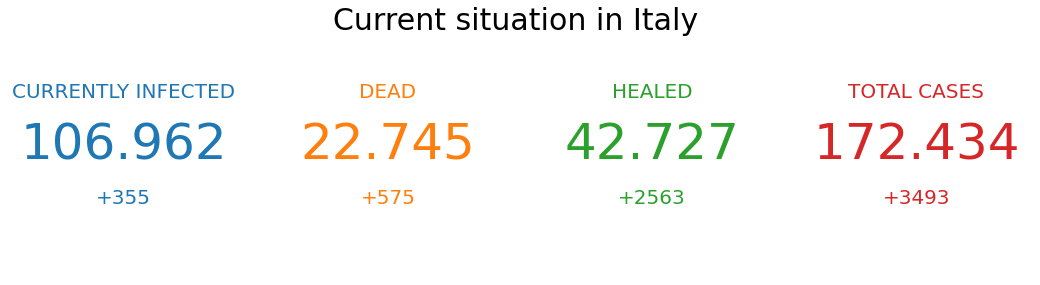

In [4]:
# Plot a summary of last day stats
totals = df_data.groupby(level='data').sum()
variations = totals - totals.shift(1)
variations = variations.iloc[-1]
totals = totals.iloc[-1]
#df_variations = 

cmap = ['#1f77b4', # totale_positivi
        '#ff7f0e', # dimessi_guariti
        '#2ca02c', # deceduti
        '#d62728'  # totale_casi
       ]

fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharey=False)

axs[0].text(0.5, 0.7, "CURRENTLY INFECTED", 
            size=20, ha="center", va="center", color=cmap[0])
axs[0].text(0.5, 0.5, "{:.3f}".format(totals['totale_positivi']/1000), 
            size=50, ha="center", va="center", color=cmap[0])
axs[0].text(0.5, 0.3, "{:+.0f}".format(variations['totale_positivi']), 
            size=20, ha="center", va="center", color=cmap[0])


axs[1].text(0.5, 0.7, "DEAD", 
            size=20, ha="center", va="center", color=cmap[1])
axs[1].text(0.5, 0.5, "{:.3f}".format(totals['deceduti']/1000), 
            size=50, ha="center", va="center", color=cmap[1])
axs[1].text(0.5, 0.3, "{:+.0f}".format(variations['deceduti']), 
            size=20, ha="center", va="center", color=cmap[1])


axs[2].text(0.5, 0.7, "HEALED", 
            size=20, ha="center", va="center", color=cmap[2])
axs[2].text(0.5, 0.5, "{:.3f}".format(totals['dimessi_guariti']/1000), 
            size=50, ha="center", va="center", color=cmap[2])
axs[2].text(0.5, 0.3, "{:+.0f}".format(variations['dimessi_guariti']), 
            size=20, ha="center", va="center", color=cmap[2])


axs[3].text(0.5, 0.7, "TOTAL CASES", 
            size=20, ha="center", va="center", color=cmap[3])
axs[3].text(0.5, 0.5, "{:.3f}".format(totals['totale_casi']/1000), 
            size=50, ha="center", va="center", color=cmap[3])
axs[3].text(0.5, 0.3, "{:+.0f}".format(variations['totale_casi']), 
            size=20, ha="center", va="center", color=cmap[3])

for s in range(4):
    axs[s].get_xaxis().set_visible(False)
    axs[s].get_yaxis().set_visible(False)
    axs[s].set_frame_on(False)

fig.suptitle('Current situation in Italy', fontsize=30)
fig.tight_layout()
plt.show()

## The trend day by day
Currently positive, healed, dead and total cases from the first detection to today. Total data and new cases day by day.

In [5]:
# Prepare the data for the daily trend by selecting the relevant columns
columns = ['totale_positivi','dimessi_guariti','deceduti','totale_casi','tamponi']

df_data_totals = df_data.groupby(level='data').sum()
df_data_totals = df_data_totals[columns] #subset of selected columns

# Create new dataset fro daily totals
df_data_totals_daily = df_data_totals[columns].copy() 

for column in columns:
    # Calculate daily difference
    df_data_totals_daily[column] = df_data_totals_daily[column] - df_data_totals_daily[column].shift(1)

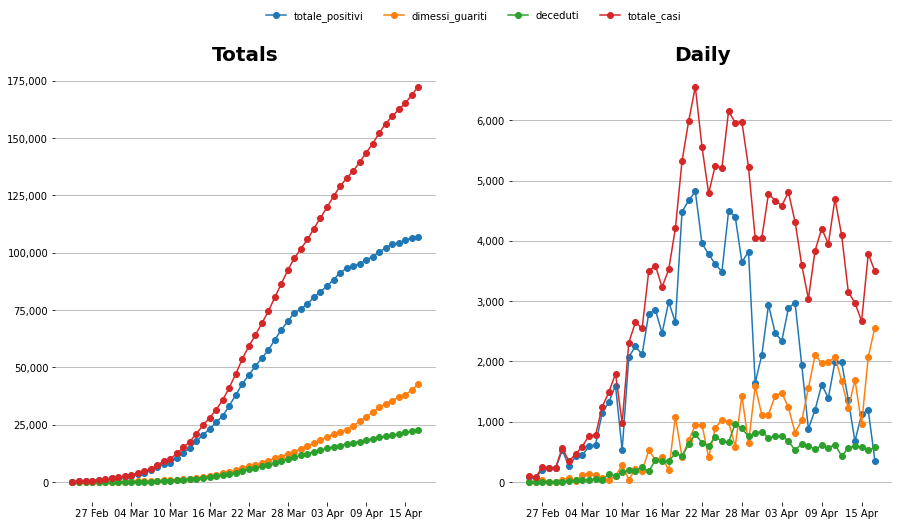

In [6]:
# Subset of columns to be plotted 
columns = ['totale_positivi','dimessi_guariti','deceduti','totale_casi']

# Plot side by side Total and Daily trends
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

for column in columns:
    axs[0].plot(df_data_totals[column],marker="o", label=column)
    axs[1].plot(df_data_totals_daily[column],marker="o", label=column)

# Common values for axis
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers
    ax.set_frame_on(False)
    ax.yaxis.grid(True)
    
axs[0].legend(ncol=4, loc='upper center', bbox_to_anchor=(1.1, 1.15), frameon=False) # Common legend for both plots
axs[0].set_title('Totals', fontsize=20, fontweight="bold")
axs[1].set_title('Daily', fontsize=20, fontweight="bold")

plt.show()

## The daily percentage change
How the growth in percentage terms of the total cases day by day varies.

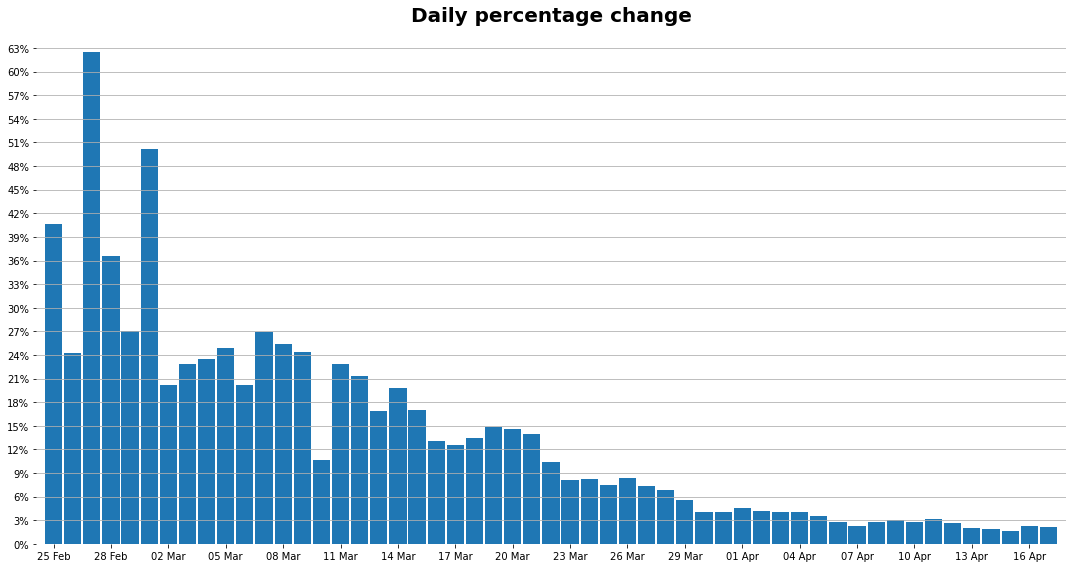

In [7]:
# Create a new dataset with percentages
df_variation_perc = (df_data_totals_daily['totale_casi']/
                             df_data_totals['totale_casi'].shift(1))*100
df_variation_perc.dropna(inplace=True)
x = mdates.date2num(df_variation_perc.index) # Convert dates to numbers for x axis
w = 0.9 # with of bars

fig, ax = plt.subplots(figsize=(15,8))

bars = ax.bar(x, df_variation_perc.round(1), width=w)

ax.set_title('Daily percentage change',fontsize=20, fontweight="bold")
ax.set_xlim(x.min()-w, x.max()+w)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3)) # Converts back x axes to dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
#ax.yaxis.set_visible(False)
ax.set_yticks(np.arange(0,ax.get_ylim()[1],3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.yaxis.grid(True)

ax.set_frame_on(False)

def autolabel(bars):
    """ Adds value above each bar """
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:+.1f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize='small',
                    ha='center', va='bottom')
#autolabel(bars)

fig.tight_layout()

## Daily swabs and infected

The number of new infected people day by day, the number of daily tests and their percentage ratio.

In [8]:
df_data_totals_daily.tail()

,totale_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,
2020-04-13,1363.0,1224.0,566.0,3153.0,36717.0
2020-04-14,675.0,1695.0,602.0,2972.0,26779.0
2020-04-15,1127.0,962.0,578.0,2667.0,43715.0
2020-04-16,1189.0,2072.0,525.0,3786.0,60999.0
2020-04-17,355.0,2563.0,575.0,3493.0,65705.0


In [9]:
df_data_totals_daily[['tamponi','totale_casi']].corr()

,tamponi,totale_casi
tamponi,1.00000,0.64339
totale_casi,0.64339,1.00000


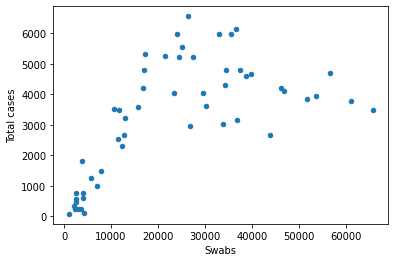

In [10]:
# Scatter plot with tamponi (swabs) and totale_positivi (total cases)
df_data_totals_daily.plot.scatter(x='tamponi', y='totale_casi')
plt.xlabel('Swabs')
plt.ylabel('Total cases')
plt.show()

In [11]:
X = df_data_totals_daily['tamponi'].dropna().values.reshape(-1,1)
y = df_data_totals_daily['totale_casi'].dropna().values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) # Training the algorithm

# To retrieve the intercept:
print(regressor.intercept_)
# For retrieving the slope:
print(regressor.coef_)

[1676.0861185]
[[0.06247592]]


In [12]:
y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,3836.0,4904.841517
1,5974.0,3890.669954
2,4585.0,4088.718611
3,5217.0,3206.995992
4,1247.0,2032.386274
5,250.0,1827.715169
6,5959.0,3738.978427
7,3599.0,3567.294607
8,5210.0,3392.986798
9,5560.0,3249.229712


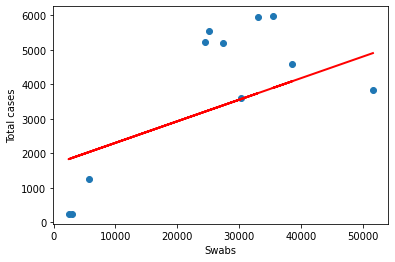

In [13]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Swabs')
plt.ylabel('Total cases')
plt.show()

In [14]:
# Spearmans's coefficient
sr, _ = spearmanr(df_data_totals_daily['tamponi'].dropna(),df_data_totals_daily['totale_casi'].dropna())
print('Spearman\'s rank correlation coefficient: {:.3f}'.format(sr))
# The mean squared error
print('Mean Square Error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Spearman's rank correlation coefficient: 0.672
Mean Square Error: 2643156.02
Coefficient of determination: 0.41


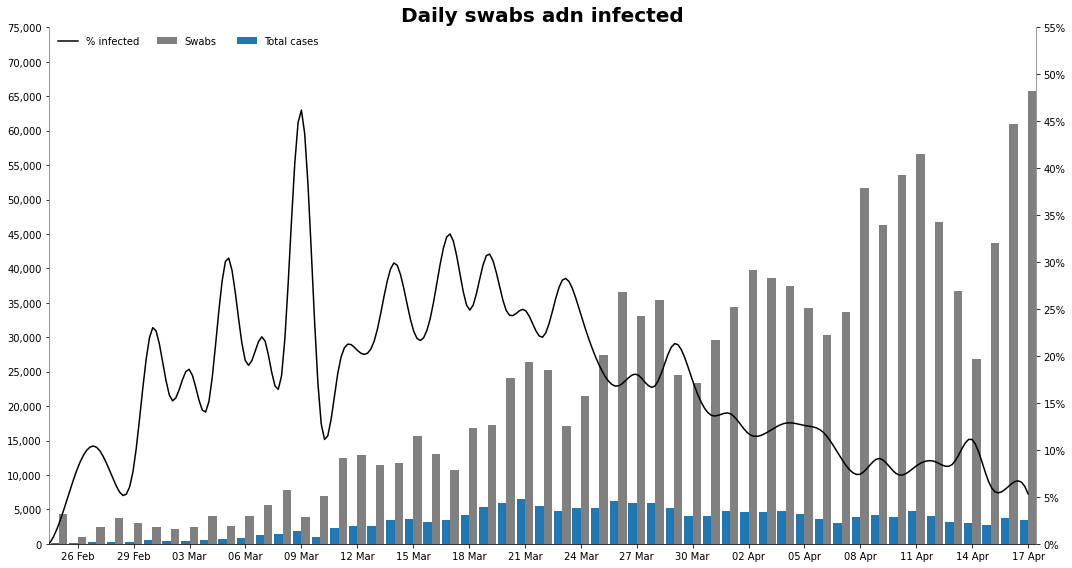

In [15]:
# Create a new dataset with swabs and infected
df_swabs_infected = df_data_totals_daily.copy()
df_swabs_infected['perc_contagiati_scoperti'] = (df_swabs_infected['totale_casi']/df_swabs_infected['tamponi'])*100
df_swabs_infected.fillna(0, limit=1, inplace=True) # Replace NaN by 0s

width = 0.45 # Width of the bars
x = mdates.date2num(df_swabs_infected.index) # Convert dates to numbers for x axis

ymax = df_swabs_infected['tamponi'].max()+5000.

# Smooth plot of percentages by interpolatation
xnew = np.linspace(x.min(),x.max(),300)
percentages = df_swabs_infected['perc_contagiati_scoperti']
spl = make_interp_spline(x, percentages, k=3)
percentages_smooth = spl(xnew)

##### PLOT #####
fig, ax1 = plt.subplots(figsize=(15,8))

## SWABS & TOTAL CASES
bars1 = ax1.bar(x + width/2, df_swabs_infected['tamponi'], width, label='Swabs',color='grey')
bars2 = ax1.bar(x - width/2, df_swabs_infected['totale_casi'], width, label='Total cases')

ax1.set_title('Daily swabs adn infected', fontsize=20, fontweight="bold")

ax1.set_xlim(x.min()+width, x.max()+width)
ax1.set_ylim(0, ymax+2000.)

(ytick1_min, ytick1_max) = (ax1.get_yticks()[0], ax1.get_yticks()[-1])
newyticks1 = np.arange(ytick1_min, ytick1_max, step=5000.)

ax1.set_yticks(newyticks1)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3)) # Converts back x axes to dates and sets interval of dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax1.legend(ncol=2,loc='upper left', bbox_to_anchor=(0.1, 1), frameon=False)
ax1.spines['left'].set_color('grey')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['left'].set_bounds(newyticks1[0],newyticks1[-1])

ax2 = ax1.twinx() # Add new axes to plot le percentages

## % INFECTED
perc = ax2.plot(xnew, percentages_smooth, color='k', label='% infected')

ax2.set_ylim(0, percentages_smooth.max()+5)

(ytick2_min, ytick2_max) = (ax2.get_yticks()[0], ax2.get_yticks()[-1])
newyticks2 = np.arange(ytick2_min, ytick2_max, step=5.)

ax2.tick_params(axis='y')
ax2.set_yticks(newyticks2)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%d%%')) # Format right axes
ax2.legend(loc='upper left', frameon=False)

ax2.spines['right'].set_color('grey')
ax2.spines['left'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_bounds(newyticks2[0], newyticks2[-1])


fig.tight_layout()

## The trend of the 5 regions with the most infections
The number of total cases in the 5 regions where coronavirus is most prevalent.

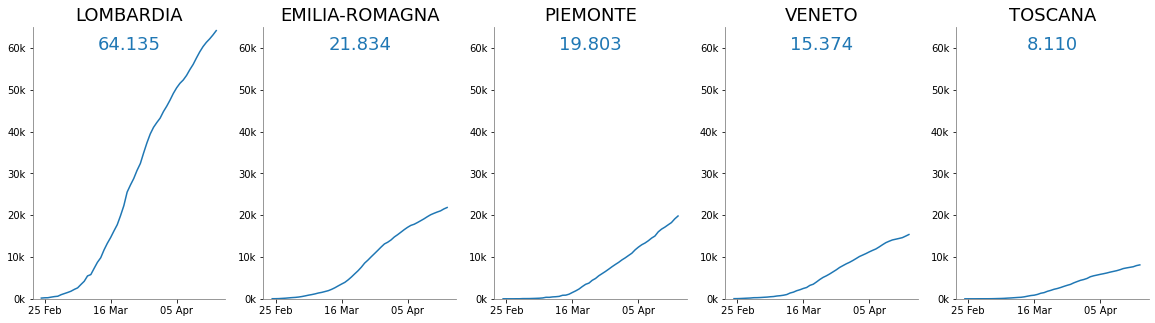

In [16]:
n = 5 # Number of cases

df_top_regions = df_data.groupby(level='denominazione_regione').sum() 
top_n_regions = df_top_regions.nlargest(n, 'totale_casi').index.tolist() # Names of top regions

df_trend_regions = df_data['totale_casi'].copy()

# Plot each single region side by side
fig, axs = plt.subplots(1, n, figsize=(20,5), sharey=True)

for ax,region in zip(axs, top_n_regions):
    maxval = df_trend_regions.xs(region, level='denominazione_regione').max()
    maxvaltext = '{:.3f}'.format(maxval/1000)
    
    # Common axes parameters
    ax.plot(df_trend_regions.xs(region, level='denominazione_regione'),label=maxval) # plot the single region
    ax.set_title('{}'.format(region.upper()), fontsize=18)
    ax.set_ylim(bottom=0, top=65000)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(str(int(x/1000))+'k')))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.yaxis.set_ticks_position('left')
    
    leg = ax.legend(loc='upper center', title=maxvaltext, frameon=False) # Plot total infected as legend
    plt.setp(leg.get_texts(), color='w')
    plt.setp(leg.get_title(), fontsize=18, color='#1f77b4')
    for item in leg.legendHandles:
        item.set_visible(False) # hide patch for each label
        
plt.show()

## The trend of intensive care and hospitalizations
The number of daily hospitalizations, those in intensive care, people in home isolation and the daily percentage growth. On the right, the percentage ratio between the individual items.

In [17]:
# Subset of columns to be plotted 
columns = ['ricoverati_con_sintomi','terapia_intensiva','isolamento_domiciliare','totale_positivi']
# Create a new dataset with columns selected
df_therapy = df_data[columns].copy()
# Group by region
df_therapy_regions = df_therapy[columns[:3]].groupby(level='denominazione_regione').sum()
df_therapy_regions.sort_values(by='terapia_intensiva',ascending=False,inplace=True)
df_therapy_regions.style.bar(subset=['ricoverati_con_sintomi'], color=['#d65f5f'], width=99)\
                        .bar(subset=['terapia_intensiva'], color=['#e69f9f'], width=99)\
                        .bar(subset=['isolamento_domiciliare'], color=['#f6dfdf'], width=99)

,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare
denominazione_regione,,,
Lombardia,390357,45515,436965
Piemonte,98422,13275,163060
Emilia-Romagna,115080,11647,229948
Veneto,47978,10049,206803
Toscana,31556,8358,99774
Marche,31874,5232,63123
Liguria,31366,5021,44575
Lazio,33889,4963,46849
Campania,15309,3241,46540


In [18]:
# Group by date
df_therapy = df_therapy.groupby(level='data').sum()
# Create dataset with percentages
df_therapy_perc = df_therapy.copy()
df_therapy_perc['ricoverati_con_sintomi'] = (df_therapy_perc['ricoverati_con_sintomi']/df_therapy_perc['totale_positivi'])*100
df_therapy_perc['terapia_intensiva'] = (df_therapy_perc['terapia_intensiva']/df_therapy_perc['totale_positivi'])*100
df_therapy_perc['isolamento_domiciliare'] = (df_therapy_perc['isolamento_domiciliare']/df_therapy_perc['totale_positivi'])*100

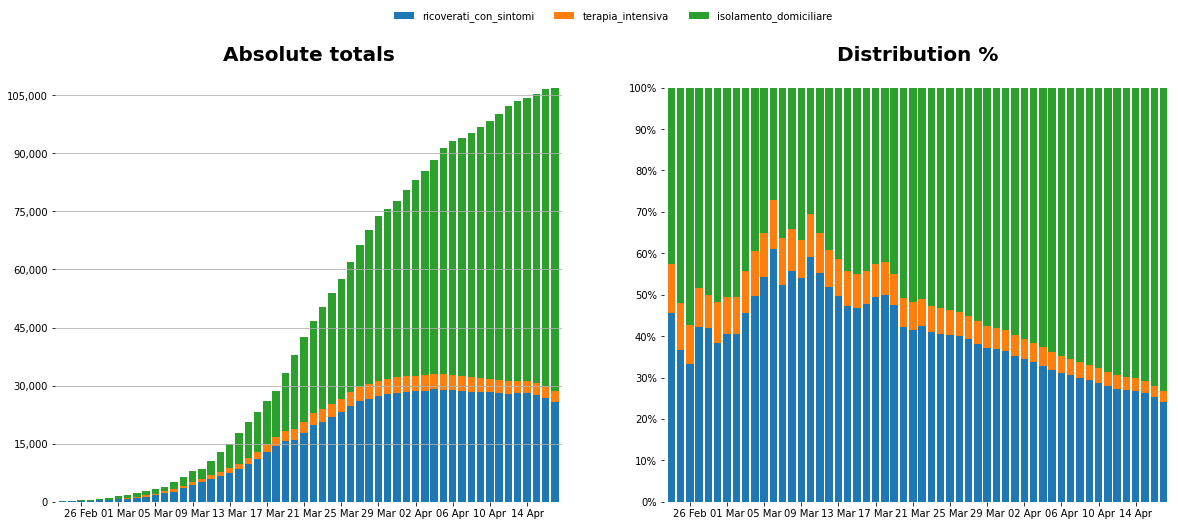

In [19]:
# Prepare data for plot
x = mdates.date2num(df_therapy.index) # Convert dates to numbers for x axis
w = 0.8 # Width of the bars

# Plot side by side absolute totals and percentages
fig, axs = plt.subplots(1,2,figsize=(20,8),sharey=False)

# Absolute totals
axs[0].bar(x, df_therapy[columns[0]], label=columns[0])
axs[0].bar(x, df_therapy[columns[1]], label=columns[1], bottom=df_therapy[columns[0]])
axs[0].bar(x, df_therapy[columns[2]], label=columns[2], bottom=df_therapy[columns[0]]+df_therapy[columns[1]])
axs[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(1.1, 1.15), frameon=False)
axs[0].set_title('Absolute totals', fontsize=20, fontweight="bold")

# Percentages
axs[1].bar(x,df_therapy_perc[columns[0]], label=columns[0])
axs[1].bar(x,df_therapy_perc[columns[1]], label=columns[1], bottom=df_therapy_perc[columns[0]])
axs[1].bar(x,df_therapy_perc[columns[2]], label=columns[2], bottom=df_therapy_perc[columns[0]]+df_therapy_perc[columns[1]])
axs[1].set_title('Distribution %', fontsize=20, fontweight="bold")

# Common values for both subplots
for ax in axs:
    ax.set_xlim(x.min()-w, x.max()+w)
    ax.set_frame_on(False)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b')) # Converts back x axes to dates and sets interval of dates

# Format y axis
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(10))
axs[0].yaxis.grid(True)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
axs[1].set_yticks(np.arange(0,110,10))

plt.show()

## Region-by-region Fatality Rate
The Case Fatality Rate (CFR) is the percentage of deaths out of the total number of infected people

In [20]:
df_fatality = df_lastday.copy()
df_fatality = df_fatality.droplevel('data')
df_fatality = df_fatality[['deceduti','totale_casi']]

# Compute totals for Italy and append to the DataFrame
df_fatality = df_fatality.append(df_fatality.sum().rename('Italia'))

# Compute CFR
df_fatality['CFR'] = (df_fatality['deceduti']/df_fatality['totale_casi'])*100
df_fatality.sort_values(by=['CFR'], ascending=False, inplace=True)
df_fatality.style.background_gradient(cmap='Reds')

,deceduti,totale_casi,CFR
denominazione_regione,,,
Lombardia,11851,64135,18.478210
Liguria,866,6188,13.994829
Marche,785,5668,13.849682
Emilia-Romagna,2903,21834,13.295777
Italia,22745,172434,13.190554
Valle d'Aosta,123,993,12.386707
Piemonte,2171,19803,10.962985
P.A. Bolzano,234,2296,10.191638
P.A. Trento,342,3376,10.130332


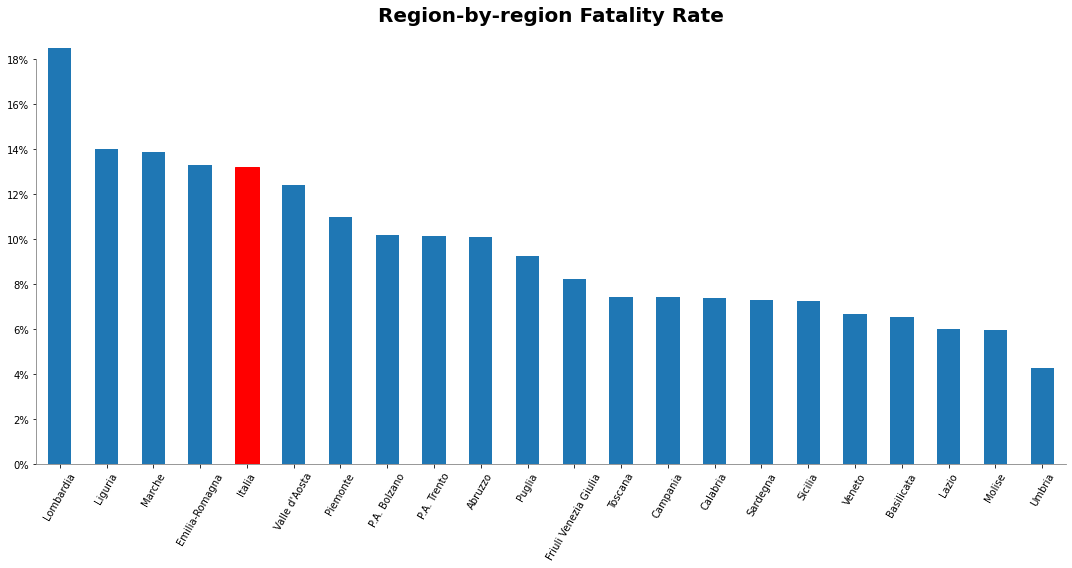

In [21]:
def findItaly(df):
    """ Finds position of "Itala" in DataFrame to color bar in red """
    return df_fatality.index.get_loc("Italia")

##### Plot #####
fig, ax = plt.subplots(figsize=(15,8))

df_fatality.plot.bar(y='CFR', ax=ax, rot=60)

pos = findItaly(df_fatality)
ax.get_children()[pos].set_color('r') # Color Italy in red
ax.set_title('Region-by-region Fatality Rate', fontsize=20, fontweight="bold")

# Format axes
(ymin,ymax) = ax.get_ylim()
ax.set_yticks(np.arange(0,ymax,2))
(minbound, maxbound) = (ax.get_yticks()[0], ax.get_yticks()[-1])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_bounds(minbound,maxbound)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f%%'))
ax.set_xlabel('')
ax.get_legend().remove()

fig.tight_layout()
plt.show()

## Deaths/Population ratio
Ratio of deaths over population by provinces

In [22]:
# Population by region at 31.12.2018 from https://www.istat.it/
data = {'Piemonte': 4356406,
                   'Valle d\'Aosta': 125666,
                   'Lombardia': 10060574,
                   'P.A. Trento': 541098,
                   'P.A. Bolzano': 531178,
                   'Veneto': 4905854,
                   'Friuli Venezia Giulia': 1215220,
                   'Liguria': 1550640,
                   'Emilia-Romagna': 4459477,
                   'Toscana': 3729641,
                   'Umbria': 882015,
                   'Marche': 1525271,
                   'Lazio': 5879082,
                   'Abruzzo': 1311580,
                   'Molise': 305617,
                   'Campania': 5801692,
                   'Puglia': 4029053,
                   'Basilicata': 562869,
                   'Calabria': 1947131,
                   'Sicilia': 4999891,
                   'Sardegna': 1639591,
                   'Italia': 60359546}
df_population = pd.DataFrame.from_dict(data, orient='index',columns=['popolazione'])
df_population.index.name = 'denominazione_regione'
df_population

,popolazione
denominazione_regione,
Piemonte,4356406
Valle d'Aosta,125666
Lombardia,10060574
P.A. Trento,541098
P.A. Bolzano,531178
Veneto,4905854
Friuli Venezia Giulia,1215220
Liguria,1550640
Emilia-Romagna,4459477


In [23]:
df_deaths = df_fatality.join(df_population)
df_deaths = df_deaths[['deceduti','popolazione']]
df_deaths['ratio_deceduti'] = (df_deaths['deceduti']/df_deaths['popolazione'])*100
df_deaths.sort_values(by='ratio_deceduti',ascending=False).style.background_gradient(cmap='Reds')

,deceduti,popolazione,ratio_deceduti
denominazione_regione,,,
Lombardia,11851,10060574,0.117796
Valle d'Aosta,123,125666,0.097879
Emilia-Romagna,2903,4459477,0.065097
P.A. Trento,342,541098,0.063205
Liguria,866,1550640,0.055848
Marche,785,1525271,0.051466
Piemonte,2171,4356406,0.049835
P.A. Bolzano,234,531178,0.044053
Italia,22745,60359546,0.037683


## The trend in the provinces with the most infections
The number of total cases in the ten provinces where coronavirus is most prevalent.

In [24]:
# Read data by provinces
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
df_data_provinces = pd.read_csv(url, parse_dates=['data'])

df_data_provinces['data'] = df_data_provinces['data'].dt.date

# Remove rows with 'In fase di definizione/aggiornamento'
mask = df_data_provinces['denominazione_provincia'] != 'In fase di definizione/aggiornamento'
df_data_provinces = df_data_provinces[mask]
provinces = df_data_provinces['denominazione_provincia'].unique().tolist()

# Set index
df_data_provinces.set_index(['data','denominazione_regione','denominazione_provincia'], inplace=True)

# Find top N provinces on last day
n = 10 
last_day = df_data_provinces.index.get_level_values(0)[-1]

#df_top_province = df_dati_province.groupby(level='denominazione_provincia').sum()
df_top_provinces = df_data_provinces.loc[last_day].groupby(level='denominazione_provincia').sum()
top_n_provinces = df_top_provinces.nlargest(n, 'totale_casi').index.tolist()
print(top_n_provinces)

['Milano', 'Brescia', 'Bergamo', 'Torino', 'Cremona', "Reggio nell'Emilia", 'Monza e della Brianza', 'Roma', 'Verona', 'Bologna']


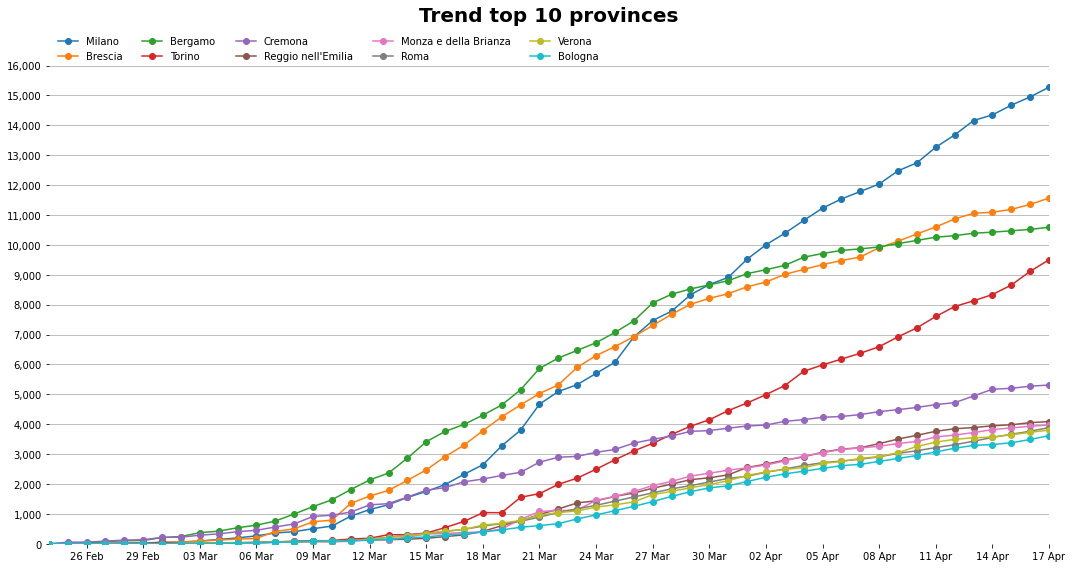

In [25]:
# Create dataset with provinces trend
df_trend_provinces = df_data_provinces['totale_casi'].copy()
df_trend_provinces = df_trend_provinces.droplevel('denominazione_regione') # Remove from index

# Prepare data for plot
x = mdates.date2num(df_trend_provinces.index.get_level_values(0)) # Convert dates to numbers for x axis
ymax = df_trend_provinces.max()+1000.
yticks = np.arange(0, ymax, step=1000.)

# Plot
fig, ax = plt.subplots(figsize=(15,8))

for province in top_n_provinces:
    ax.plot(df_trend_provinces.xs(province, level='denominazione_provincia'), marker="o", label=province)

ax.set_xlim(x.min(), x.max())
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b')) # Converts back x axes to dates and sets interval of dates
ax.set_ylim(0, ymax+1000.)
ax.set_yticks(yticks)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers
ax.yaxis.grid(True)

ax.set_title('Trend top {} provinces'.format(n), fontsize=20, fontweight="bold")
ax.legend(ncol=5,loc='upper left', frameon=False)

ax.set_frame_on(False)

fig.tight_layout() 

## The coronavirus map in Italy
The data of infections are aggregated by province and deaths by region.

In [26]:
col = ['lat','long','totale_casi']
df_data = df_data_provinces.loc[last_day][col]
df_data = df_data.droplevel('denominazione_regione')
df_data.name = 'province' # From italian to english
df_data.sort_index()

,lat,long,totale_casi
denominazione_provincia,,,
Agrigento,37.309711,13.584575,132
Alessandria,44.912974,8.615401,2696
Ancona,43.616760,13.518875,1686
Aosta,45.737503,7.320149,993
Arezzo,43.466428,11.882288,541
...,...,...,...
Vercelli,45.323981,8.423234,935
Verona,45.438390,10.993527,3805
Vibo Valentia,38.676241,16.101574,70


In [27]:
# Import GeoJSON data of italian provinces boundaries
#url_it_prov = 'https://gist.githubusercontent.com/datajournalism-it/212e7134625fbee6f9f7/raw/dabd071fe607f5210921f138ad3c7276e3841166/province.geojson'
with open('IT_provinces.geojson') as f:
  italy_geojson = json.load(f)

# The total number of provinces
n_provinces = len(italy_geojson['features'])

# The provinces names
province_names = [italy_geojson['features'][k]['properties']['NOME_PRO'] for k in range(n_provinces)]
print("There are {} provinces".format(n_provinces))

There are 110 provinces


Depending on the resolution of your geojson and on the purpose of your map, you might consider downsampling the longitude and latitude coordinates. Downsampling the coordinates will decrease the resolution of the borders, but it will speed up the rendering time

In [28]:
def downsample(sample = 10):
    sources = []
    geojson_copy = copy.deepcopy(italy_geojson['features']) # do not oeverwrite the original file

    for feature in geojson_copy:

        if sample > 0:
            coords = np.array(feature['geometry']['coordinates'][0][0])
            coords = coords[::sample]
            feature['geometry']['coordinates'] = [[coords]]

        sources.append(dict(type = 'FeatureCollection',
                            features = [feature])
                      )
    return sources

In [29]:
# Extract geometryc coordinates of provinces
sources = downsample(5)
g_provinces = [sources[k]['features'][0]['geometry']['coordinates'] for k in range(n_provinces)]

In [30]:
def toPoint(list): 
    return Point(tuple(list))

# Genereate polygons of provinces
polygons = []
for i in range(len(g_provinces)):
    points = [toPoint(g) for g in g_provinces[i][0][0]]
    polygons.append(Polygon(points))

d = {'denominazione_provincia':province_names, 'geometry': polygons}
df_mappa = pd.DataFrame(data=d)
df_mappa.set_index('denominazione_provincia', inplace=True)

In [31]:
# Match the province names of dataframe and geojson
def match_regions(list1, list2):
    # take only the best match
    matched = [process.extract(list1[i], list2, limit=1, scorer=fuzz.partial_ratio)[0][0] for i in range(0,len(list1))]

    return {key: value for (key, value) in zip(list1, matched)}

match_dict = match_regions(df_data.index, province_names)
print(match_dict)

{'Chieti': 'Chieti', "L'Aquila": "L'Aquila", 'Pescara': 'Pescara', 'Teramo': 'Teramo', 'Matera': 'Matera', 'Potenza': 'Potenza', 'Bolzano': 'Bolzano', 'Catanzaro': 'Catanzaro', 'Cosenza': 'Cosenza', 'Crotone': 'Crotone', 'Reggio di Calabria': 'Reggio Calabria', 'Vibo Valentia': 'Vibo Valentia', 'Avellino': 'Avellino', 'Benevento': 'Benevento', 'Caserta': 'Caserta', 'Napoli': 'Napoli', 'Salerno': 'Salerno', 'Bologna': 'Bologna', 'Ferrara': 'Ferrara', 'Forlì-Cesena': 'Forl\x8d-Cesena', 'Modena': 'Modena', 'Parma': 'Parma', 'Piacenza': 'Piacenza', 'Ravenna': 'Ravenna', "Reggio nell'Emilia": 'Reggio Emilia', 'Rimini': 'Rimini', 'Gorizia': 'Gorizia', 'Pordenone': 'Pordenone', 'Trieste': 'Trieste', 'Udine': 'Udine', 'Frosinone': 'Frosinone', 'Latina': 'Latina', 'Rieti': 'Rieti', 'Roma': 'Roma', 'Viterbo': 'Viterbo', 'Genova': 'Genova', 'Imperia': 'Imperia', 'La Spezia': 'La spezia', 'Savona': 'Savona', 'Bergamo': 'Bergamo', 'Brescia': 'Brescia', 'Como': 'Como', 'Cremona': 'Cremona', 'Lecco':

In [32]:
df_tmp = df_data.copy() # do not overwrite the dataframe
df_tmp.index = df_tmp.index.map(match_dict) # rename
df_tmp = df_tmp[~df_tmp.index.duplicated(keep=False)] # drop duplicates
                                                      # from fuzzy match gone wrong
# Give the same index order as the geojson
df_reindexed = df_tmp.reindex(index = province_names)
df_reindexed

,lat,long,totale_casi
denominazione_provincia,,,
Vercelli,45.323981,8.423234,935.0
Novara,45.445885,8.621916,1855.0
Torino,45.073274,7.680687,9503.0
Cuneo,44.393296,7.551172,1897.0
Valle d'Aosta,45.737503,7.320149,993.0
...,...,...,...
Catania,37.502878,15.087047,745.0
Potenza,40.639471,15.805148,167.0
Ragusa,36.925092,14.730699,69.0


In [33]:
# Create a new dataset by adding geometry points to reindexed dataset
df_reindexed_map = df_reindexed.merge(df_mappa, left_index=True, right_index=True)
df_reindexed_map

,lat,long,totale_casi,geometry
denominazione_provincia,,,,
Vercelli,45.323981,8.423234,935.0,"POLYGON ((8.204465116243027 45.93567475731711,..."
Novara,45.445885,8.621916,1855.0,"POLYGON ((8.496878361658412 45.83933925448746,..."
Torino,45.073274,7.680687,9503.0,"POLYGON ((7.859044264361275 45.59758444387668,..."
Cuneo,44.393296,7.551172,1897.0,"POLYGON ((7.99089719465156 44.82381138833528, ..."
Valle d'Aosta,45.737503,7.320149,993.0,"POLYGON ((7.588571915813588 45.97075085043372,..."
...,...,...,...,...
Catania,37.502878,15.087047,745.0,"POLYGON ((15.09013209641676 37.49971885346178,..."
Potenza,40.639471,15.805148,167.0,"POLYGON ((15.72353494486009 39.96828910017415,..."
Ragusa,36.925092,14.730699,69.0,"POLYGON ((14.49320600045339 36.78657623003762,..."


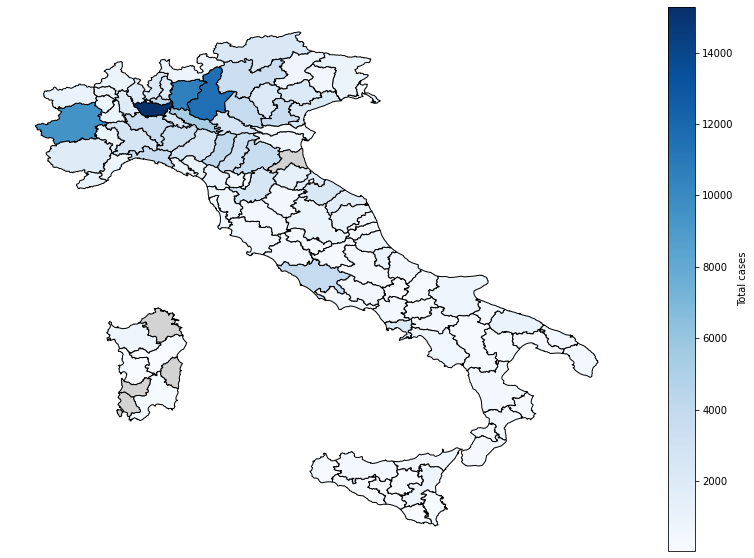

In [34]:
# Create geopandas dataset to plot the map
gdf = geopandas.GeoDataFrame(df_reindexed, geometry=geopandas.points_from_xy(df_reindexed.long, df_reindexed.lat))
italy = geopandas.GeoDataFrame(df_reindexed_map, geometry='geometry')

fig, ax = plt.subplots(figsize=(15,10))
italy.plot(ax=ax, column='totale_casi', cmap='Blues', legend=True, edgecolor='k',
          legend_kwds={'label': "Total cases"},
          missing_kwds={
              "color": "lightgrey",
              "label": "Missing values",
          })

ax.axis('off')

plt.show()

## Climatic data and correlation to infections
Here we try to see correlation between new infecteds and mean temperature in the province of Milan

In [35]:
df_meteo = pd.read_csv('meteo_2020_milano.csv', sep=';', parse_dates=['data'], dayfirst=True)
df_meteo.set_index(['data'], inplace=True)
df_meteo.tail()

,localita,t_media,t_min,t_max,punto_rugiada,umidita,visibilita_km,vento_media,vento_max,raffica,pressione_slm,pressione_media,pioggia,fenomeni
data,,,,,,,,,,,,,,
2020-04-10,Milano,16,7,25,4,45,20,4,9,0,1022,0,0,NaN
2020-04-11,Milano,18,7,26,4,39,20,6,9,0,1021,0,0,NaN
2020-04-12,Milano,17,8,25,2,28,20,7,13,0,1019,0,0,NaN
2020-04-13,Milano,17,9,23,3,36,20,8,15,0,1014,0,0,NaN
2020-04-14,Milano,17,11,25,7,48,21,20,42,0,1012,0,0,NaN


In [36]:
# Select province and save data
province = 'Milano'
df_prov = df_data_provinces.xs(province, level='denominazione_provincia').copy()
df_prov = df_prov.droplevel('denominazione_regione') # Get rid of secondary index
df_prov = df_prov[['totale_casi']] # Save only total cases
df_prov_daily = df_prov - df_prov.shift(1)
df_prov_daily.dropna(inplace=True)
df_prov_daily.tail()

,totale_casi
data,
2020-04-13,481.0
2020-04-14,189.0
2020-04-15,325.0
2020-04-16,277.0
2020-04-17,325.0


In [37]:
# Join both dataframes
t_cols = ['t_media','t_min','t_max']
df_joined = df_meteo[t_cols].join(df_prov_daily, on='data')
df_joined.dropna(inplace=True)
df_joined.tail()

,t_media,t_min,t_max,totale_casi
data,,,,
2020-04-10,16,7,25,269.0
2020-04-11,18,7,26,520.0
2020-04-12,17,8,25,412.0
2020-04-13,17,9,23,481.0
2020-04-14,17,11,25,189.0


In [38]:
df_joined.describe()

,t_media,t_min,t_max,totale_casi
count,50.00000,50.000000,50.000000,50.000000
mean,10.68000,4.760000,15.880000,287.000000
std,3.53663,3.027493,5.037168,217.411488
min,5.00000,-1.000000,7.000000,0.000000
25%,8.00000,2.250000,12.000000,88.000000
50%,10.00000,5.000000,15.000000,260.500000
75%,13.00000,6.750000,19.000000,421.000000
max,18.00000,13.000000,26.000000,868.000000


In [39]:
df_joined[['t_media','totale_casi']].corr()

,t_media,totale_casi
t_media,1.000000,0.296977
totale_casi,0.296977,1.000000


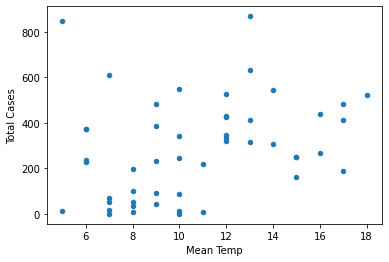

In [40]:
# Scatter plot with t_media and totale_casi
df_joined.plot.scatter(x='t_media', y='totale_casi')
plt.xlabel('Mean Temp')
plt.ylabel('Total Cases')
plt.show()

In [41]:
X = df_joined['t_media'].values.reshape(-1,1)
y = df_joined['totale_casi'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) # Training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[115.80250444]
[[16.54910274]]


In [42]:
y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,375.0,215.097121
1,94.0,264.744429
2,70.0,231.646224
3,308.0,347.489943
4,7.0,248.195326
5,230.0,215.097121
6,387.0,264.744429
7,547.0,281.293532
8,318.0,314.391737
9,1.0,231.646224


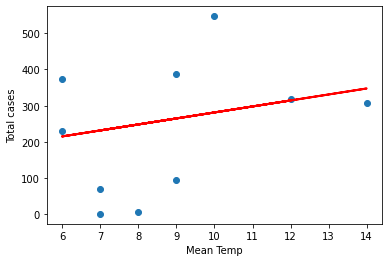

In [43]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Mean Temp')
plt.ylabel('Total cases')
plt.show()

From the plot we can see that there is no significant correlation between mean temperature and total daily cases, Now let's find out the statistics parameters

In [44]:
# Spearmans's coefficient
sr, _ = spearmanr(df_joined['t_media'],df_joined['totale_casi'])
print('Spearman\'s rank correlation coefficient: {:.3f}'.format(sr))
# The mean squared error
print('Mean Square Error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Spearman's rank correlation coefficient: 0.368
Mean Square Error: 27956.59
Coefficient of determination: 0.09


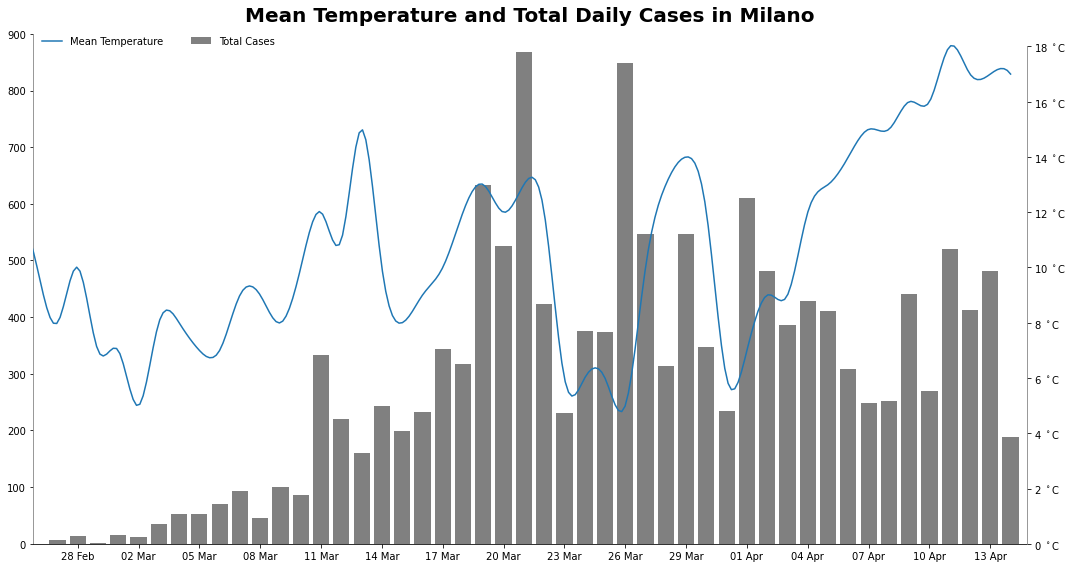

In [45]:
##### Plot data
width = 0.8 # Width of the bars
x = mdates.date2num(df_joined.index) # Convert dates to numbers for x axis

# Smooth plot of percentages by interpolatation
xnew = np.linspace(x.min(),x.max(),300)
temperature = df_joined['t_media']
spl = make_interp_spline(x, temperature, k=3)
temperature_smooth = spl(xnew)

### PLOT ###
fig, ax1 = plt.subplots(figsize=(15,8))
## TOTAL CASES
bars = ax1.bar(x, df_joined['totale_casi'], width,label='Total Cases',color='grey')
ax1.set_title('Mean Temperature and Total Daily Cases in {}'.format(province), fontsize=20, fontweight="bold")

ax1.set_xlim(x.min()+width, x.max()+width)
(ytick1_min, ytick1_max) = (ax1.get_yticks()[0], ax1.get_yticks()[-1])
newyticks1 = np.arange(ytick1_min, ytick1_max, step=100.)
ax1.set_yticks(newyticks1)

ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3)) # Converts back x axes to dates and sets interval of dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax1.legend(ncol=2,loc='upper left', bbox_to_anchor=(0.15, 1), frameon=False)
ax1.spines['left'].set_color('grey')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['left'].set_bounds(newyticks1[0],newyticks1[-1])

ax2 = ax1.twinx()
## MEAN TEMPERATURE
lines = ax2.plot(xnew, temperature_smooth, label='Mean Temperature')

ax2.tick_params(axis='y')
(ytick2_min, ytick2_max) = (ax2.get_yticks()[0], ax2.get_yticks()[-1])
newyticks2 = np.arange(0, ytick2_max, step=2)
ax2.set_yticks(newyticks2)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%d $^\circ$C')) # Format right axes
ax2.legend(loc='upper left', frameon=False)

ax2.spines['right'].set_color('grey')
ax2.spines['left'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_bounds(ax2.get_yticks()[0], ax2.get_yticks()[-1])

fig.tight_layout()